<h2> Imports </h2>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import warnings
warnings.filterwarnings("ignore")

#import libraries
import numpy as np 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas import DataFrame
import seaborn as sns 
import matplotlib.pyplot as plt

#other imports
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE
from sklearn.grid_search import GridSearchCV
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import RandomUnderSampler

#import metrics
from sklearn import cross_validation
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from collections import Counter

#import classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

#shows automatically the plots - no more plt.show() needed!
%matplotlib inline 
#increase label size
import matplotlib 
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
matplotlib.rc('font', **font)

#allow to display all columns
pd.set_option('display.max_columns', 100)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

#from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


<h3>Read the Data </h3>

In [2]:
#import the training data as pandas dataframe
train = pd.read_csv('../input/train.csv')

In [ ]:
#import the test data as pandas dataframe
test = pd.read_csv('../input/test.csv')

In [6]:
#let's take a look at the top 10 instances
train.head(10)

,id,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0
5,19,5,1,4,0,0,0,0,0,1,0,0,0,0,0,6,1,0,0,0.9,1.8,2.332649,10,0,-1,0,0,14,1,1,0,1,104,2,0.445982,0.879049,0.406202,3.000000,0.7,0.8,0.4,3,1,8,2,11,3,8,4,2,0,9,0,1,0,1,1,1
6,20,2,1,3,1,0,0,1,0,0,0,0,0,0,0,8,1,0,0,0.6,0.1,0.617454,6,1,-1,0,1,11,1,1,0,1,99,2,0.316228,0.639683,0.368782,3.162278,0.2,0.6,0.5,2,2,8,1,8,3,10,3,0,0,10,0,1,0,0,1,0
7,22,5,1,4,0,0,1,0,0,0,0,0,0,0,0,13,1,0,0,0.7,0.4,0.607248,11,1,0,0,0,11,1,1,2,1,30,3,0.446990,0.900574,0.374833,3.316625,0.1,0.5,0.1,1,2,7,1,6,1,13,7,1,3,6,1,0,1,0,1,0
8,26,5,1,3,1,0,0,0,1,0,0,0,0,0,0,6,1,0,0,0.9,0.7,0.901388,10,1,-1,0,1,14,1,1,0,1,68,3,0.400000,0.780641,0.407431,2.828427,0.9,0.8,0.6,3,1,7,3,9,4,11,4,2,1,5,0,1,0,0,0,1
9,28,1,1,2,0,0,0,1,0,0,0,0,0,0,0,4,0,0,1,0.9,1.4,2.316652,11,0,0,1,0,14,1,1,2,1,104,2,0.447214,1.458184,0.390256,3.605551,0.7,0.8,0.8,2,2,8,2,9,1,11,3,5,0,6,0,1,0,0,1,0


In [ ]:
#top 10 instances of the test dataset
test.head(10)

In [3]:
#I placed the following before so i can work on oversampling later on . 
#drop target from train !
label = train['target']
train = train.drop(['target'], axis=1)
cols=train.columns

<h3> Grouping into feature Type - used for Data visualization </h3>

In [4]:
#create grouping for continous, ordinal, categorical and binary to better work with the individual groups
#code used from Bert Carremans https://www.kaggle.com/bertcarremans/data-preparation-exploration 

data = []
for f in train.columns:
#     # Defining the role
#     if f == 'target':
#         role = 'target'
#     elif f == 'id':
#         role = 'id'
#     else:
#         role = 'input'
         
    # Defining the level
    if 'bin' in f or f == 'target':
        level = 'binary'
    elif 'cat' in f:
        level = 'nominal'
    elif f == 'id':
        level='id'
    elif train[f].dtype == float:
        level = 'interval'
    elif train[f].dtype == int:
        level = 'ordinal'

    
    # Creating a Dict that contains all the metadata for the variable
    fdict = {
        'varname': f,
        #'role': role,
        'level': level
    }
    data.append(fdict)
    
meta = pd.DataFrame(data, columns=['varname', 'level'])
meta.set_index('varname', inplace=True)

In [5]:
meta

,level
varname,
id,id
ps_ind_01,ordinal
ps_ind_02_cat,nominal
ps_ind_03,ordinal
ps_ind_04_cat,nominal
ps_ind_05_cat,nominal
ps_ind_06_bin,binary
ps_ind_07_bin,binary
ps_ind_08_bin,binary


<h3> Descriptive statistics </h3>

In [7]:
#assing only the continous values to n
i = meta[(meta.level =='interval')].index 
#.index is needed to return the values

#basic analysis of train data
train[i].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


As we grouped the input variables above into 4 main groups we can deal with them more easily. Instead of looking at the mean, standard deviation and the quartiles of e.g. categorical features, we can only select the features where statistical analysis actually makes sense. 
Some of the continous features have missing values, such as *ps_reg_03*, *ps_car_12* and *ps_car_14*. Later on, we'll look at how much missing data each of the features have and deal with them. 

In [21]:
o = meta[(meta.level == 'ordinal')].index
train[o].describe()

,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_car_11,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,1.900378,4.423318,0.012451,7.299922,2.346072,2.372081,1.885886,7.689445,3.005823,9.225904,2.339034,8.433590,5.441382,1.441918,2.872288,7.539026
std,1.983789,2.699902,0.127545,3.546042,0.832548,1.117219,1.134927,1.334312,1.414564,1.459672,1.246949,2.904597,2.332871,1.202963,1.694887,2.746652
min,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,5.000000,2.000000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000
50%,1.000000,4.000000,0.000000,7.000000,3.000000,2.000000,2.000000,8.000000,3.000000,9.000000,2.000000,8.000000,5.000000,1.000000,3.000000,7.000000
75%,3.000000,6.000000,0.000000,10.000000,3.000000,3.000000,3.000000,9.000000,4.000000,10.000000,3.000000,10.000000,7.000000,2.000000,4.000000,9.000000
max,7.000000,11.000000,4.000000,13.000000,3.000000,5.000000,6.000000,10.000000,9.000000,12.000000,7.000000,25.000000,19.000000,10.000000,13.000000,23.000000


From the statistics we can see that there are quite different scales present and that there is only one feature that has missing values. 

In [ ]:
#look at the class distribustion
targetcounts = train.groupby('target').size()
print(targetcounts)

We already assumed that there are more customers who are not likely to claim than there are who will. From the above result we can see that there are aprox. 26 times more customers who did not file a claim. 3.78% of the customers filed a claim which shows us that the dataset is quite unbalanced.

<h2>1. Data Analysis</h2>

<h3>1.1 Continous input variable</h3>

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f129cbfa940>,
      dtype=object)

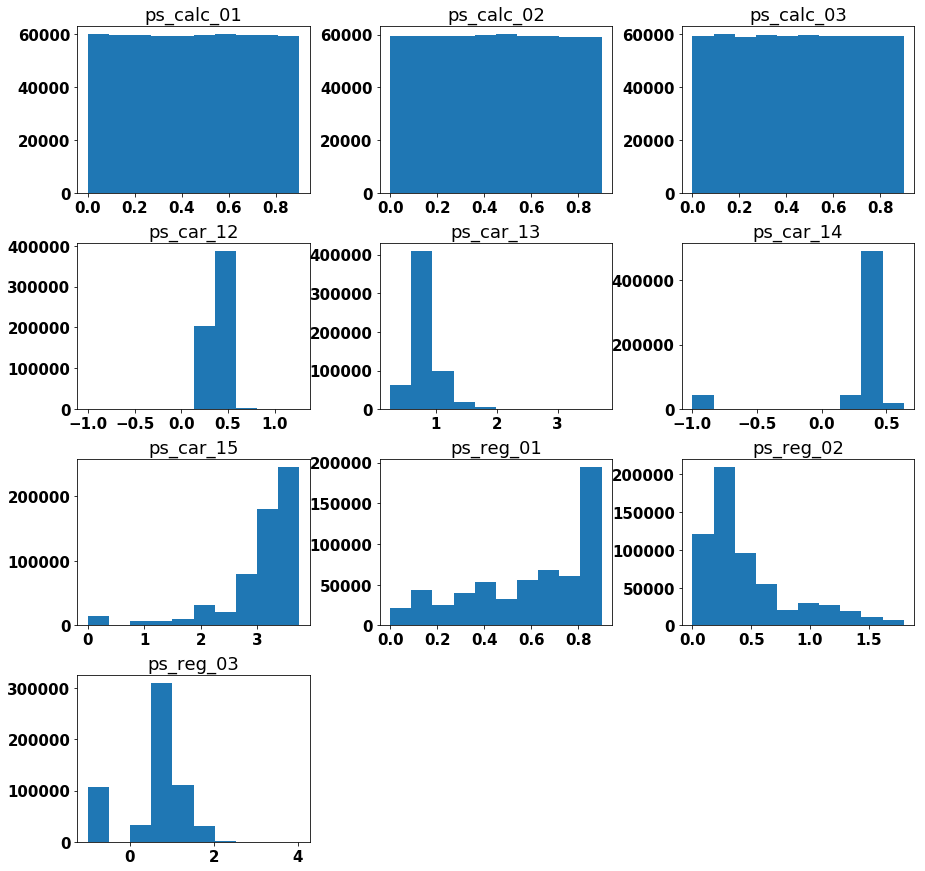

In [20]:
train[i].hist(figsize=(15,15), grid=False)

For feature *ps_car_11* the first quartile takes on values between 1 and 2 and the median is simultaniously the median. Due to the low amount in the value 0, it is considered to be an outlier. The boxplot of *ps_car_12* shows that there are a lot of irregularities within the data, as a lot of ouliers are "identified". Looking at the histogram, however, we can see that most of the data fall below 0.5. The same can be said for *ps_car_13* as we can see in the boxplot that there are too much  points to be considered as outliers. Since these values are continous, the decision boundaries in the boxplot are not quite representative. However, what we can see from the histogram above is that this feature is right skewed and has most of its values in the left side of the graph. However, we can assume that the left side of the data distribution is not considered to be an outlier. *Ps_car_14* similarly has most of the instances in the limit of 0.25 to 0.5. It seems to considere values above 0.5 as outliers and below 0.25 as well. Looking at the histogram we could assume that due to the closeness of the values to the peaked one, they are not considered to be outliers. Lastly, *ps_car_15* has more than 50% of the data instances above the value 3. Here again, the values 1.5, 1 and 0 are considered to be outliers which we do not see as plausible enough. 

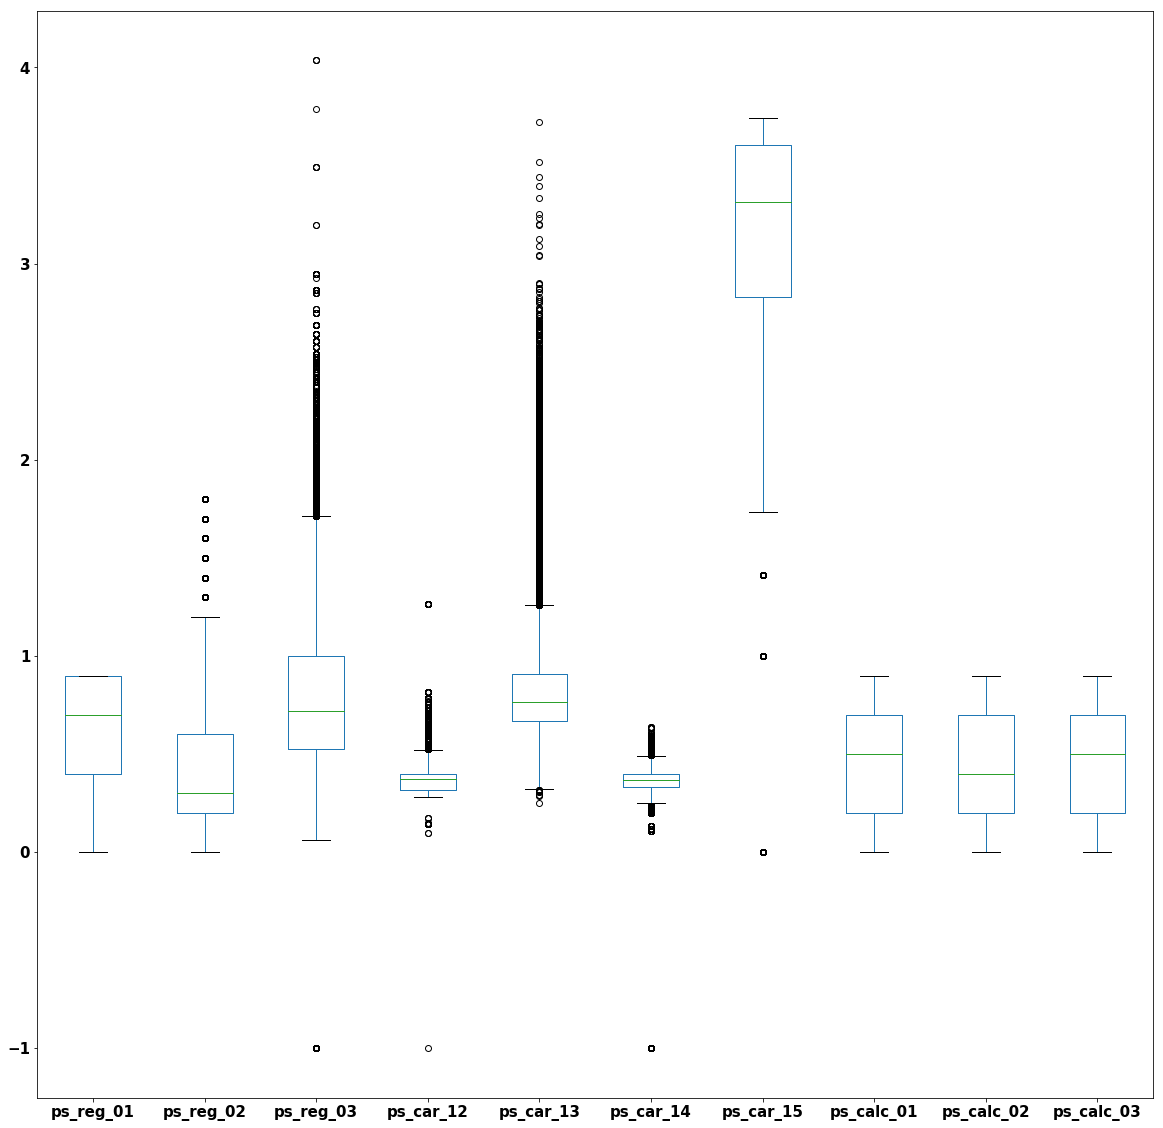

In [18]:
train[i].boxplot(figsize=(20,20),grid=False)

The boxplots for the regional features show us that feature *ps_reg_02* and *ps_reg_03*  have a comparable high amount of outliers, although the histogram of the features would not indicate them as outliers.. Furthermore, the missing values for *ps_reg_03* need to be analyzed as the amount of them seems to be quite high if we look at the histogram. 

<h3>1.2 Ordinal input variable </h3>

In [ ]:
train[o].hist(figsize=(15,15), grid=False)

We see that *ps_ind_01* and *ps_ind_15 *have a higher range of values than *ps_ind_14*. Furthermore, we can see that some values seem to occur obviously more often as the others. Almost all customers have the value 0  of the feature *ps_ind_14* , which seems to be interesting. 

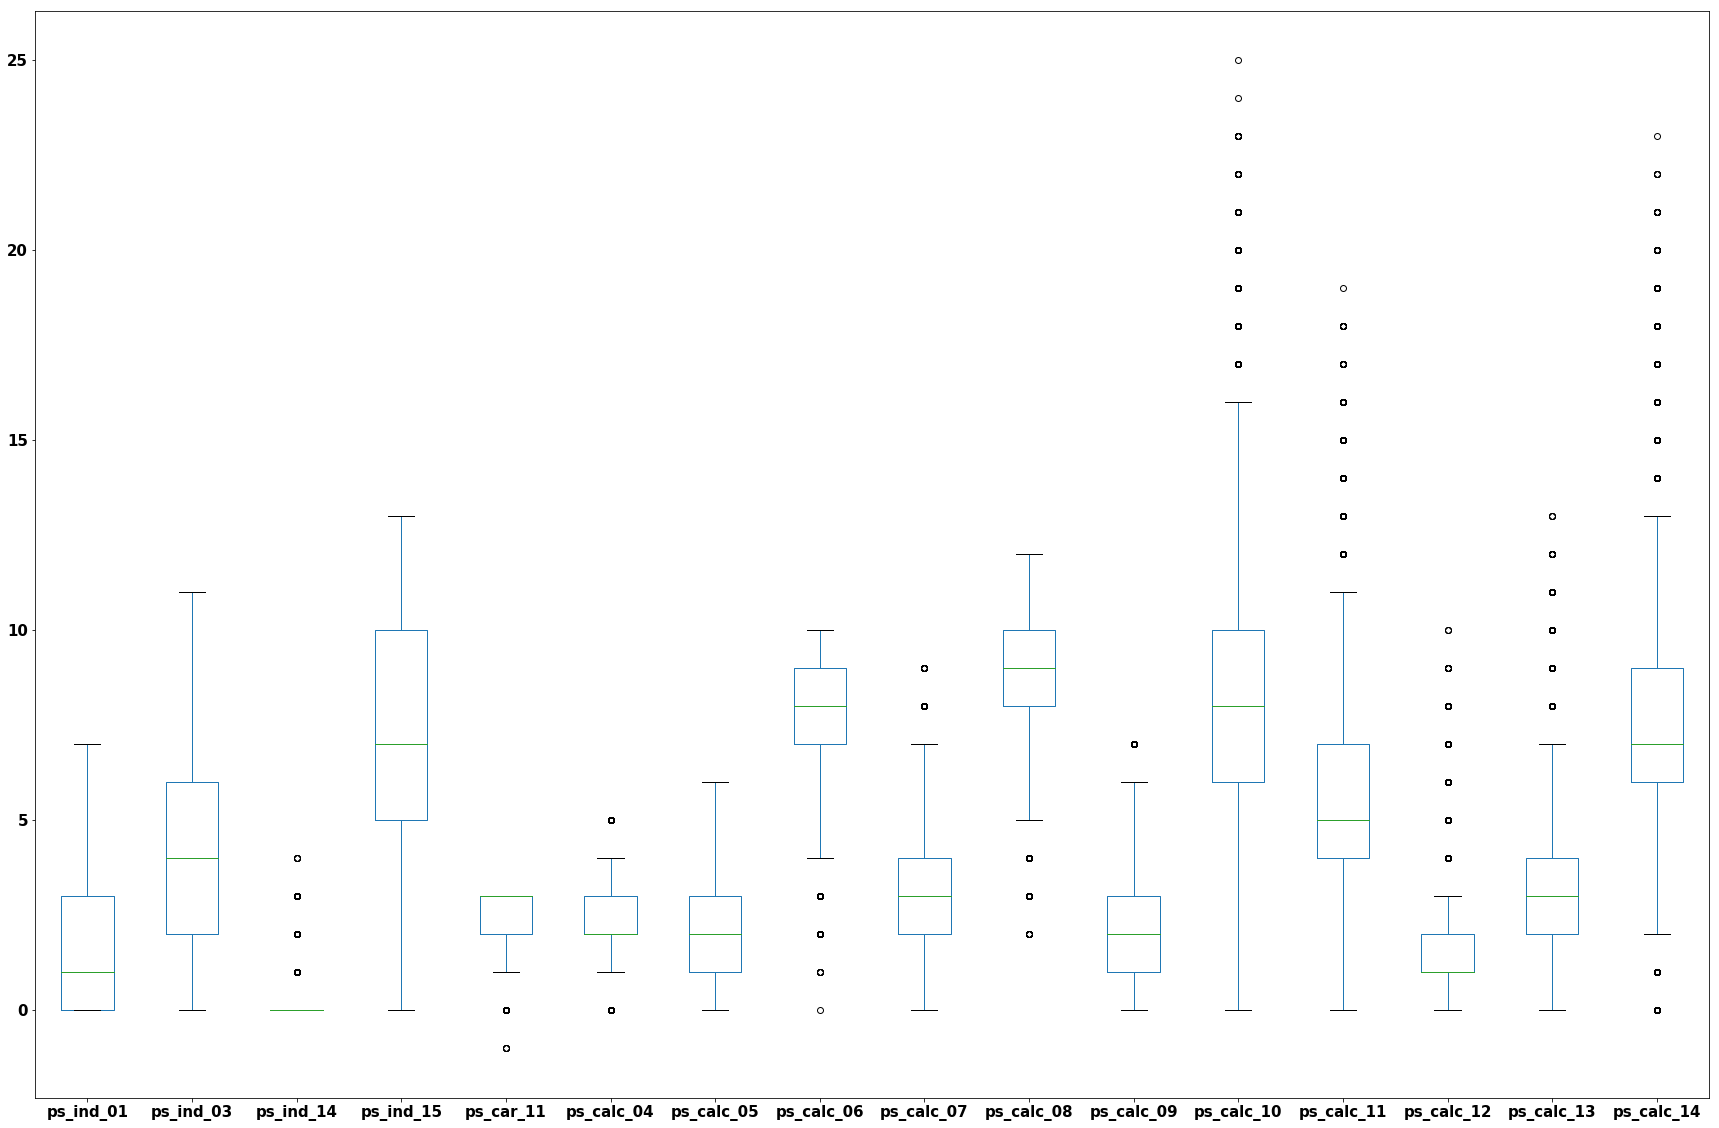

In [23]:

train[o].boxplot(figsize=(30,20), grid=False)

Boxplots are a good way to look at the min and max ranges of features and to  identify outliers. The first feature *ps_ind_01* for example has 75% of the data between 0 and 3; the other values ranging from 3 to 7 are in the last quartile. Feature *ps_ind_14* has its median at 0 and some few instances that are greater than 0. Comparing the boxplot to the histogram, we see similarities as the most frequent value was 0 with a few values of 1,2,3 and 4. The feature *ps_ind_15* on the other hand shows us the minimal value 0, the maximal value 13 and the median 7. Both features *ps_ind_01* and *ps_ind_15* seem not to have any outliers.

<h3> Binary input variables </h3>

In [ ]:
b = meta[(meta.level == 'binary')].index
train[b].hist(figsize=(15,15), grid=False)

The values of the boolean features of customers do not include any missing information, as can be seen in the histograms.  The features *ps_ind_10_bin* and *ps_ind_11_bin* should be further examined whether they have other values as well, as the majority of values falls into 0. It would be interesting to know, wheter the two features have any correlation to the target variable and if not whether we can drop them. 

<h3> Categorical input variables </h3>

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f129da0c748>,
      dtype=object)

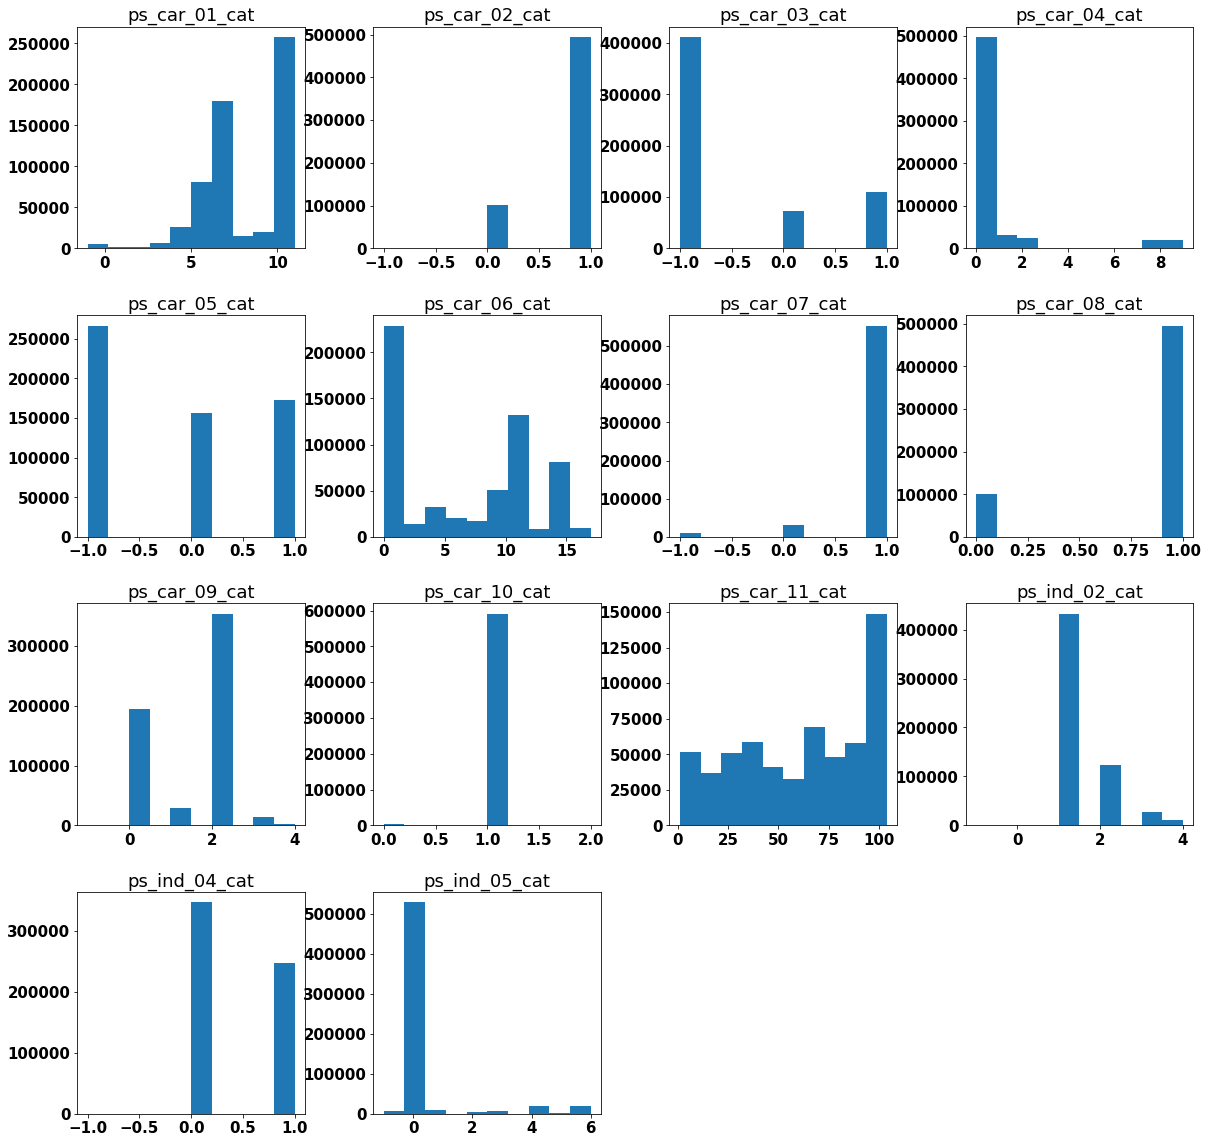

In [34]:
c = meta[(meta.level == 'nominal')].index
train[c].hist(figsize=(20,20),grid=False)

The categorical features of individuals all have some minor missing values, as can be seen at the '-1' column. There are values that are as well occuring more often than the others.  
The missing values of the categorical features can be replaced by the mode. 

Looking at the categorical features of the group car we can see that some of the featues include missing values such as *ps_car02_cat* and can be dealt with by e.g. using the mode to replace the missing values. However, if we look further at the plotted features we can see that two features, *ps_car_03_cat* and *ps_car_05_cat* have more missing values than observed instances. Therefore we suggest to drop the features from our analysis.

The data of the categorical features of the cars seem to be more spread than the other features seen so far. The first difference that can be seen is the difference in scales, as *ps_car_11_cat* ranges from 0 to above 100. It would be interesting to identify what car feature can have more than 100 possible categorical values. Nevertheless, to better read the graph we will consider another graph without *ps_car_11_cat*.

The features which almost purely have one categorical value should be further examined whether they have any influence on the target variable or not. We assume that if they do not influence the outcome, they can be dropped to increase the performance of the learning model. 

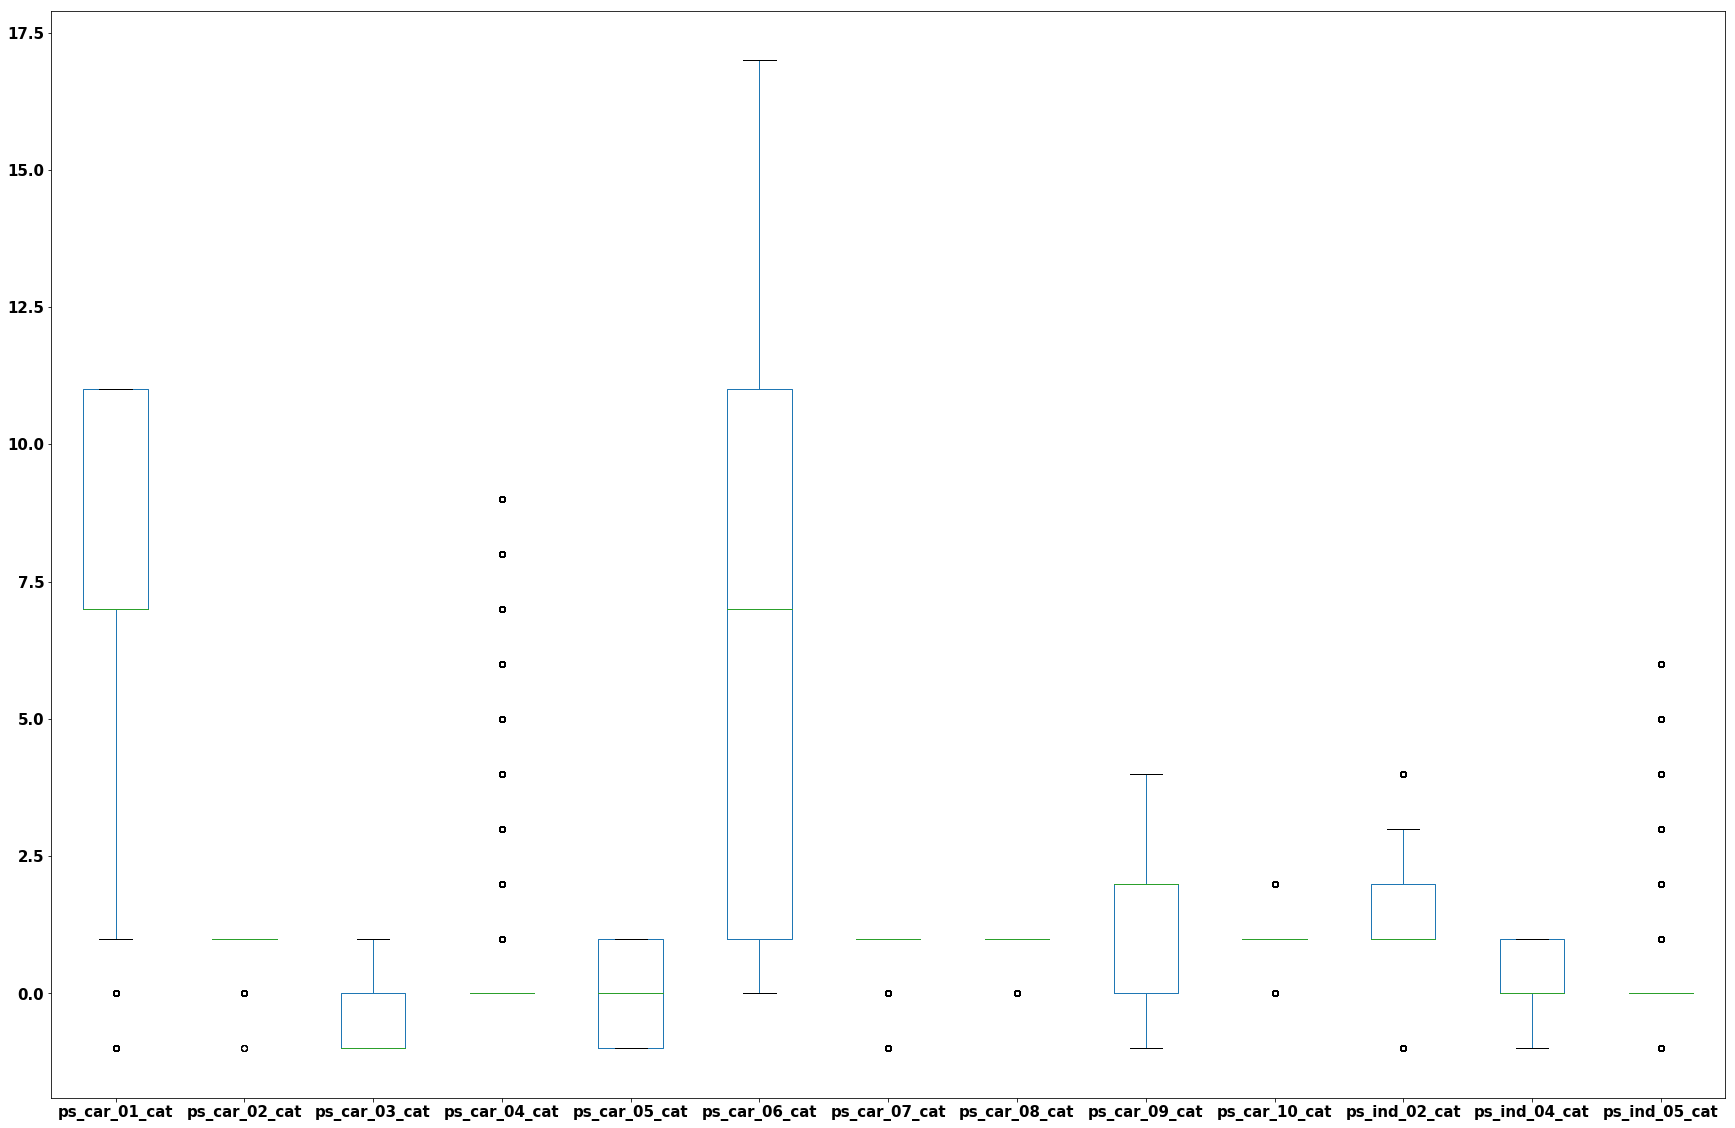

In [33]:
#for the boxplot drop the ps_car_11_cat because it has a much higher scale
exc = train[c.difference(['ps_car_11_cat'])]
exc.boxplot(figsize=(30,20),grid=False)

Now that we have removed *ps_car_11_cat* from the other categorical values of the group car, we can look closer into each of them. To begin with, *ps_car_01_cat* has missing values, however, the amount of them is quite low considering the histogram above. Similarly, *ps_car_02_cat* has its median at 1 and consideres the missing values as outliers. Looking at the histogram above, we can say that there are not many missing values and therefore we can deal with them in a next step. The feature *ps_car_03_cat* seems to be not quite useful, as it consideres the missing values as the median. Looking at the histogram, we can see that the majority of values is missing. Dealing with that feature will be difficult as a representative deflection can most probably not be made. *Ps_car_04_cat* has the median at 0 and the boxplot considers all other values as outliers. This might be true, considering the histogram. However, what can be assumed is that the value "8" is considered to be extreme, as it falls out of the range of the other possible values. *Ps_car_05_cat* considers the missing values as well in the first quartile which means that there are quite a lot of missing values. Looking at the histogram we can confirm that, as missing values are the majority. Here again we should think about whether keeping that feature actually makes sense or not.  *Ps_car_06_cat* shows us that the frist 25% of the data falls already between 0 and 1. The last quartile ranges from 11 to 17. *Ps_car_07_cat* seems to have allmost all values at 1 as the median is 1 and considers 0 and -1 as outliers. However, looking at the histogram we can see that the majority of values is 1 but still some of them are 0. Likewise, *ps_car_08_cat* has the median at 1 and consideres 0 as an outlier. However, this is probably not true but we can assume that the feature takes on one category only in minor situations. The boxplot of *ps_car_09_cat* consideres the missing values as the minimal amount of the first quartile. *Ps_car_10_cat* has a median of 1, considering that there are no plotted boxes for the other quartiles we can assume that 1 is the most occured value. Here again, the smaller amount of other categorical values (0 and 2) are considered to be outliers as they do not occur often. 

The feature *ps_ind_02_cat* has a median of 1 which is also the minimal value. -1 is correctly classified as outlier, as it is not a categorie but idicates a missing value. Since the amount of missing values is not too high, we can think of dealing with it in the data preparation step later on. The feature *ps_ind_05_cat* has median at 0 and it does not consider the values greater than 0 as represenative ranges. Looking at the histogram, it handles the values as outliers since the amount of them is much smaller than the zeros. Lastly, feature *ps_ind_04_cat* takes the missing values as minimal values of the first quartile. However, comparing the boxplot to the histogram it cannot be clearly traceable as the amount of -1s is significantly low compared to the 0s and 1s. 

In [ ]:
train.boxplot(figsize=(5,5),grid=False, column=['ps_car_11_cat'])

In [ ]:
train.hist(figsize=(5,5),grid=False, column=['ps_car_11_cat'], bins=100)

<h2>Comparison to claim rates</h2>

In [35]:
#CATEGORICAL FEATURES
for f in exc:
    g = sns.factorplot(x=f, y="target",data=train,
                   kind="bar", size=4, ci=None)
   

ValueError: Could not interpret input 'target'

In [ ]:
#code used from Bert Carremans https://www.kaggle.com/bertcarremans/data-preparation-exploration
cat_perc = train[['ps_car_11_cat', 'target']].groupby(['ps_car_11_cat'],as_index=False).mean()
cat_perc.sort_values(by='target', ascending=False, inplace=True)
g=sns.factorplot(x="ps_car_11_cat",y="target", data=cat_perc, order=cat_perc['ps_car_11_cat'],size=15, kind="bar")

By sorting the columns, we can see that there are three values that seem to be most influencal. We will use these three values to create dummy variables and group the remaining once into a "ohers" value. 

In [ ]:
#ordinal features
for f in o:
    g=sns.factorplot(x=f, y="target", data=train, kind="bar", size=4, ci=None)

In [ ]:
#continous features -> takes very long to load
for f in i:
    g=sns.factorplot(x=f,y="target", data=train, kind="bar", size=4, ci=None)

Some of the features have a lot of possible values, which is why the plot seems to be quite unreadable. From those plots *ps_car_12* and *ps_car_13* look interesting as there are some values which reach almost 100% of the target varialbe. 

*Detailed analysis of the continuous features with a lot of possible values:*

In [ ]:
#ps_reg_03
m=train.query('target==1 and ps_reg_03>ps_reg_03.mean()')['ps_reg_03'].count()
all=train.query('target==1 and ps_reg_03 >=-1')['id'].count()
percent_reg_03=m*100/all
percent_reg_03

In [ ]:
#ps_reg_03 above mean below 3rd quartile
m=train.query('target==1 and ps_reg_03>ps_reg_03.mean() and ps_reg_03<ps_reg_03.quantile(0.75)')['ps_reg_03'].count()
all=train.query('target==1 and ps_reg_03 >=-1')['id'].count()
percent_reg_03=m*100/all
percent_reg_03

78% of the customers who had a value that was greater than the mean of *ps_reg_03* filed a claim. However, 48% of the customers who were above the mean but below the upper quartile filed a claim.

In [ ]:
#ps_car_12 
m=train.query('target==1 and ps_car_12>ps_car_12.mean()')['ps_car_12'].count()
all=train.query('target==1 and ps_car_12 >=-1')['id'].count()
percent_car_12=m*100/all
percent_car_12

In [ ]:
#ps_car_12 
m=train.query('target==1 and ps_car_12>ps_car_12.mean() and ps_car_12<ps_car_12.quantile(0.75)')['ps_car_12'].count()
all=train.query('target==1 and ps_car_12 >=-1')['id'].count()
percent_car_12=m*100/all
percent_car_12

55% of the customers that had a value of feature *ps_car_12*  above the mean filed a claim. However, only aprox. 5% of the customers where the value fell into the upper quartile filed a claim. 

In [ ]:
#ps_car_13
m=train.query('target==1 and ps_car_13>ps_car_13.mean()')['ps_car_13'].count()
all=train.query('target==1 and ps_car_13 >=-1')['id'].count()
percent_car_13=m*100/all
percent_car_13

In [ ]:
#ps_car_13
m=train.query('target==1 and ps_car_13>ps_car_13.mean() and ps_car_13<ps_car_13.quantile(0.75)')['ps_car_13'].count()
all=train.query('target==1 and ps_car_13 >=-1')['id'].count()
percent_car_13=m*100/all
percent_car_13

50% of the customers that had a value of feature *ps_car_13*  above the mean filed a claim and 16% filed a claim if the values went above the upper quartile. 

In [ ]:
#ps_car_14
m=train.query('target==1 and ps_car_14>ps_car_14.mean()')['ps_car_14'].count()
all=train.query('target==1 and ps_car_14 >=-1')['id'].count()
percent_car_14=m*100/all
percent_car_14

In [ ]:
#ps_car_14 3rd quartile
m=train.query('target==1 and ps_car_14>ps_car_14.mean() and ps_car_14<ps_car_14.quantile(0.75)')['ps_car_14'].count()
all=train.query('target==1 and ps_car_14 >=-1')['id'].count()
percent_car_14=m*100/all
percent_car_14

91% of the customers, who had a value above the mean filed a claim. That's an incredible high percentage. if the customers had a value above the mean but below the upper quartile there were still 63% of them which filed a claim. 

In [ ]:
#ps_car_14 3rd quartile
m=train.query('target==1 and ps_car_14>ps_car_14.mean() and ps_car_14<ps_car_14.quantile(0.75)')['ps_car_14'].count()
all=train.query('target==1 and ps_car_14 >=-1')['id'].count()
percent_car_14=m*100/all
percent_car_14

If we look at the 3rd quantile, then aproximately 28% of the customers filed a claim. Customers that had values greater than the mean but smaller the third quartile are aprox 63%.

In [ ]:
#car13=[]
#for f in train["ps_car_13"]:
 #   if float(f) > 0.5:
  #      car13.append(f)

#for f in car13:
 #   g=sns.factorplot(x="ps_car_13",y="target",data=train, kind="bar",ci=None,size=6)
    

In [ ]:
#group all binary features together except of target variable for the analysis
exct = train[b.difference(['target'])]

In [ ]:
#BINARY FEATURES
for f in exct:
    g=sns.factorplot(x=f, y="target", data=train,
                     kind="bar",size=4, ci=None)

In 55% of the cases a file was claimed if the feature ps_car_12 was above the mean.

<h2> Missing values </h2>


In [ ]:
#code form https://www.kaggle.com/bertcarremans/data-preparation-exploration 
for f in train.columns:
    mv = train[train[f]==-1][f].count()
    if mv > 0:
        mvp = mv/train.shape[0] * 100 #train.shape[0] refers to the rows, [1] would refer to the columns
        mvp =round(mvp)
    
        print (' Variable ', f, ' has ', mvp , 'percent missing')    

As was said before, we can drop the two variables *ps_car_03_cat* and *ps_car_05_cat* as the missing values are quite high. The continuous features will be replaced by the mean and the ordinal ones by the mode. 

In [ ]:
#drop the two features
train.drop(['ps_car_03_cat','ps_car_05_cat'], inplace=True, axis=1)
#drop id, because it's not from interest
train.drop(['id'], inplace=True, axis=1)

#check whether the columns have been deleten
train.shape

In [ ]:
#update missing values with mean
imputermean = Imputer(missing_values=-1, strategy="mean")

train['ps_reg_03'] = imputermean.fit_transform(train[['ps_reg_03']]).ravel()
train['ps_car_12'] = imputermean.fit_transform(train[['ps_car_12']]).ravel()
train['ps_car_14'] = imputermean.fit_transform(train[['ps_car_14']]).ravel()

#update missing values with mode
imputermode = Imputer(missing_values=-1, strategy="most_frequent")

train['ps_car_11'] = imputermode.fit_transform(train[['ps_car_11']]).ravel()


Now we replaced allmissing values of the  continous variables with the mean and used the mode for the ordinal inputs. We could furhter analyze the missing values and look at the correlations and groupings to make a more accurate replacement instead of just using the mean or mode. However, for the beginning we will stick to this approach and we can tweak it later on to see how it improves accuracy.

In [ ]:
#check whether test data set has missing values at all

for f in test.columns:
    mv = test[test[f]==-1][f].count()
    if mv > 0:
        mvp = mv/test.shape[0] * 100
        print (' Variable ', f, ' has ', mvp , 'percent missing')    

If we want to use our model that we will fit on the training data, we need to also treat the missining values in the testing data. We will use the same imputer to the testdata. 

In [ ]:
#drop the two features from the test dataset as well
test.drop(['ps_car_03_cat','ps_car_05_cat'], inplace=True, axis=1)
#drop id, because it's not from interest
test.drop(['id'], inplace=True, axis=1)

#check whether the columns have been deleten
test.shape

In [ ]:

test['ps_reg_03'] = imputermean.fit_transform(test[['ps_reg_03']]).ravel()
test['ps_car_12'] = imputermean.fit_transform(test[['ps_car_12']]).ravel()
test['ps_car_14'] = imputermean.fit_transform(test[['ps_car_14']]).ravel()
test['ps_car_11'] = imputermode.fit_transform(test[['ps_car_11']]).ravel()

 <h3>2. Correlation Analysis </h3> <h4> not used (only if I want to apply PCA)</h4>

In [ ]:
#look at the correlations between the variables
corr = train.corr()
cormatrix = plt.subplots(figsize=(20, 15))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr)

The correlation matrix above shows us that there are some features which correlate to each other, either positively or negatively. We can also clearly see that the calculated features do not have any correlation with each other nor with other features. To enable a better readability we will exclude the calculated features from the graph. 

**Note**: First I created a correlation matrix (between all features except the calculation features). however, it does not make sense to do that as correlation between categorical features and continuous cannot be compared. If only quantitative features than we can use .corr() which is pearson correlation. For categorical features we can use chi squared and for continuous vs. categorical we can use anova. 

In [ ]:
#create an array with all the features without the calculation features
withoutcalcfeatures = []
for f in train.columns:
    if 'calc' not in f:
        withoutcalcfeatures.append(f)
# filter the features that do not include the calc featues
withoutcalc = train.drop(withoutcalcfeatures,axis=1) 

In [ ]:
n = meta[(meta.level =='interval')].index 

g= sns.pairplot(train, vars=[n])

In [ ]:
#Scatterplot for the numeric values individual

g = sns.pairplot(train, vars=['ps_ind_01','ps_ind_14','ps_ind_15'])

In [ ]:
#Scatterplot for the numeric values car
g = sns.pairplot(train, vars=['ps_car_11','ps_car_12','ps_car_13', 'ps_car_14', 'ps_car_15'])

In [ ]:
#Scatterplot for the numeric values region
g = sns.pairplot(train, vars=['ps_reg_01','ps_reg_02','ps_reg_03'])

In [ ]:
#Scatterplot for the numeric values calculation
g = sns.pairplot(train, vars=['ps_calc_01','ps_calc_02','ps_calc_03','ps_calc_04','ps_calc_05','ps_calc_06','ps_calc_07','ps_calc_08','ps_calc_09','ps_calc_10','ps_calc_11','ps_calc_12','ps_calc_13','ps_calc_14'])

todo: 
1) Look at the correlations between features - if some have a correlation maybe i can apply PCA to reduce the amount of feautes;  heat map from above and look at the closer ones more into detail. 
2) look at correlation to target variable 
3) use the features and look at the distribution if grouped to 0 or 1. to see whether there are any patterns. - features with low variance or 0 variance - drop them. 

<h3> Scaling </h3> - **not used - not effecting the model much**

In [ ]:
# from sklearn import preprocessing
# x = trainnewweka.values #returns a numpy array
# min_max_scaler = preprocessing.MinMaxScaler()
# x_scaled = min_max_scaler.fit_transform(x)
# dfsc = pd.DataFrame(x_scaled, columns=trainnewweka.columns)

<h2> Feature Selection </h2> :
<h3>Feature selection using Variance Threshold.</h3>

In [ ]:
#select the threshold - 90% of the samples  need to be the same to be dropped
sel = VarianceThreshold(threshold=0.1)
#sel.fit(train)  # not needed
#sel.fit_transform(train.drop(['target'], axis=1)) #target should not be considered to be analyzed on variance;   now that we dropped the target upfront we dont need it anymore
sel.fit_transform(train)

# we get an array of boolean features back which of the featues were selected.
#code from https://www.kaggle.com/bertcarremans/data-preparation-exploration 
f = np.vectorize(lambda x : not x) # Function to toggle boolean array elements

v = train.columns[f(sel.get_support())]
print('These {} variables have too low variance and will be dropped (Threshold 90%):'.format(len(v)))
print('{}'.format(list(v)))

 **eliminate features with 0 or low variance because they usually have low predictive power.**
https://stats.stackexchange.com/questions/145602/justification-for-feature-selection-by-removing-predictors-with-near-zero-varian 

**Feature importance using random forest**

In [ ]:
#cross validation for train set - to analyze feature importance using RF
x_train, x_test, y_train, y_test = cross_validation.train_test_split(
     train, label, test_size=0.3)

In [ ]:
#Look at feature importance through random forest

#feature importance without dropping the ones with low variance and creating dummy variables
rf = RandomForestClassifier(n_estimators=100, random_state=1, n_jobs=-1)
rf.fit(x_train, y_train)


# code from Igor Manzhos found at https://stackoverflow.com/questions/41900387/mapping-column-names-to-random-forest-feature-importances
importances = list(zip(train.columns, rf.feature_importances_))
importances.sort(reverse=True)
print (importances)

In [ ]:
# plot thanks to https://www.fabienplisson.com/choosing-right-features/
importances=rf.feature_importances_
importances = pd.DataFrame({'feature':train.columns,'importance':np.round(rf.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.plot.bar(figsize=(25,5))

In [ ]:
from sklearn.feature_selection import SelectFromModel
# minimum threshold is the median of the feature importances
sfm = SelectFromModel(rf, threshold=0.021)
sfm.fit(x_train, y_train)
n_features = sfm.transform(x_train).shape[1]
newvars = list(cols[sfm.get_support()]) #getfeatures names and asign it to newvars, so that we can access it later

In [ ]:
trainnewrandom= train[newvars]

Run 1: Interesting is that the variance threshold said the ps_reg_03 should be dropped due to too high variance. However, looking at the feature importance of the random forest ps_reg_03 seems to be the strongest predictor. Even if we look at our detailed analysis from this feature, we idetified that 78% of the customers claimed a file if that feature was above the mean. As a next step it should be evaluated how much percent of the feature actually fall above the mean. If the amount is high, I'd suggest to create a dummy variable which checks whether that feature is above the mean or not. and if so use it as predictor. so we can discard the feature ps_reg_03.  

Run 2: After creating dummy variables for all features, we ended up having 194 features. Looking at the importance of each feature using the random forest we identified that ps_car_11_cat has some important values such as ps_car_11_cat_99  until ps_car_!1_cat_90 and then also ps_car_11_cat9. Although the feature has 104 categories they seem to be important and hence should not be dropped. After undersampling our model we can try a model with only 50 features and see how it performs. 

<h3> Features selection using WEKA datamining tool </h3> (forward selection)

In [ ]:
#select the 9 features that were identified to lead to a good subset from weka
#features: ps_ind_07_bin, ps_ind_12_bin, ps_ind_17_bin, ps_reg_02, ps_car_07_cat, ps_car_12, ps_car_13,ps_calc_01
subff =[]
for f in train.columns:
    if f != 'ps_ind_07_bin' and f !='ps_ind_12_bin' and f != 'ps_ind_17_bin' and f != 'ps_reg_02'  and f !='ps_car_07_cat' and f !='ps_car_12' and f != 'ps_car_13' and f != 'ps_calc_01':
        subff.append(f)

(backward selection)

In [ ]:
#backward selec from weka
subfback =[]
for f in train.columns:
    if f != 'ps_ind_05_cat' and f !='ps_ind_06_bin' and f != 'ps_ind_07_bin' and f != 'ps_ind_12_bin' and f !='ps_ind_16_bin' and f !='ps_ind_17_bin' and f != 'ps_reg_02' and f != 'ps_reg_03' and f != 'ps_car_02_cat' and f != 'ps_car_03_cat' and f != 'ps_car_07_cat' and f != 'ps_car_12' and f != 'ps_car_13' and f != 'ps_car_15':
        subfback.append(f)

In [ ]:
featuresKag =[]
for f in train.columns:
     if f != 'ps_ind_01' and f !='ps_ind_03' and f != 'ps_ind_05_cat' and f != 'ps_ind_07_bin' and f !='ps_ind_15' and f !='ps_ind_16_bin' and f != 'ps_reg_01' and f != 'ps_reg_03' and f != 'ps_reg_02' and f != 'ps_car_01_cat' and f != 'ps_car_03_cat' and f != 'ps_car_07_cat' and f != 'ps_car_12' and f != 'ps_car_13'  and f != 'ps_car_14' and f != 'ps_car_15':
        featuresKag.append(f)

<h3> Drop the selected Features <h3>
Variance Threshold

In [ ]:
#create copy of train and drop the 14 features that have a too low variance
#if we create dummy variables for all the categorical features we can drop 164 features because they have a too low variance
trainnew = train.drop(v, axis=1)



<h3>Forward Selection WEKA </h3>

In [ ]:
trainnewweka= train.drop(subff, axis=1)

<h3> Backwardselection WEKA </h3>                      

In [ ]:
trainwekaback = train.drop(subfback, axis=1)

In [ ]:
#features from https://www.kaggle.com/ogrellier/noise-analysis-of-porto-seguro-s-features
trainnew = train.drop(featuresKag,axis=1)

<h2> Create Dummy Variables </h2>

1. On variance threshold selected features

In [ ]:
#create array with only the categorical features
dumv = []
for f in trainnew.columns:
    if 'cat' in f:
        dumv.append(f)


trainnew = pd.get_dummies(trainnew, columns=dumv, drop_first=True)

 
 2 . On featues selected through WEKA forward selection:

In [ ]:
#create array with only the categorical features for trainnewweka 
dumvarweka = []
for f in trainnewweka.columns:
    if 'cat' in f:
        dumvarweka.append(f)


trainnewweka = pd.get_dummies(trainnewweka, columns=dumvarweka, drop_first=True)

3 . on features selected through WEKA backward selection:

In [ ]:
#create array with only the categorical features for trainnewweka 
dumvarwekaback = []
for f in trainwekaback.columns:
    if 'cat' in f:
        dumvarwekaback.append(f)


trainwekaback = pd.get_dummies(trainwekaback, columns=dumvarwekaback, drop_first=True)

In [ ]:
dumvarfeatimport = []
for f  in trainnewrandom:
    if 'cat' in f:
        dumvarfeatimport.append(f)

trainnewrandom = pd.get_dummies(trainnewrandom, columns=dumvarfeatimport, drop_first=True)

<h1> Training the models </h1>
<h3> Iterations 1-5 </h3>

**KNN **

In [ ]:
#knn = KNeighborsClassifier(n_neighbors=bestVal, n_jobs=-1).fit(x_train, y_train)
knn = KNeighborsClassifier(n_neighbors=1, n_jobs=-1).fit(x_train, y_train)
knnscore = knn.score(x_test,y_test)
results['KNN'] = (1-knnscore)
print ('Prediction accuracy:', knnscore)

<h2> Later iteartions - change in featue selection! </h2>


**Select only X most important features **
Tutorial - https://chrisalbon.com/machine_learning/trees_and_forests/feature_selection_using_random_forest/

In [ ]:
# new RF classifierr
clf = RandomForestClassifier(n_estimators=200, random_state=0, n_jobs=-1)

# Train the classifier
clf.fit(x_train, y_train)

#setting a seed  to create repeateble settings. othervise feature importance will always be different based on which features the model selects.

# Print the name and gini importance of each feature
for feature in zip(reversed(cols), clf.feature_importances_):
    print(feature)

**Select most important features**

In [ ]:
# Create a selector object that will use the random forest classifier to identify
# features that have an importance of more than 0.007 .(ps_car_06_cat_1)
sfm = SelectFromModel(clf, threshold=0.01)

# Train the selector
sfm.fit(x_train, y_train)

**Print names of most important featues**

In [ ]:
# print names of the most important features with threshold 0.0007
for feature_list_index in sfm.get_support(indices=True):
    print(cols[feature_list_index])

**Create subset of features to train new model**

In [ ]:
# Transform the data to create a new dataset containing only the most important features
# Note: We have to apply the transform to both the training X and test X data.
X_imp_train = sfm.transform(x_train)
X_imp_test = sfm.transform(x_test)

In [ ]:
# Create a new random forest classifier for the most important features
clf_important = RandomForestClassifier(n_estimators=500, random_state=0, n_jobs=-1)

# Train the new classifier on the new dataset containing the most important features
clf_important.fit(X_imp_train, y_train)

In [ ]:
# Apply The Full Featured Classifier To The Test Data
y_imp_pred = clf_important.predict(X_imp_test)

# View accuracy of RF with selected features
accuracy_score(y_test, y_imp_pred)

In [ ]:
confusion_matrix(y_test,y_imp_pred)

<h1> Oversampling </h1>

#tutorial on oversampling found on http://contrib.scikit-learn.org/imbalanced-learn/stable/over_sampling.html

In [ ]:
#cross validation trainnew
x_train, x_test, y_train, y_test = cross_validation.train_test_split(
     trainnew, label, test_size=0.3)

In [ ]:
#cross validation for train set - to analyze feature importance using RF
x_train, x_test, y_train, y_test = cross_validation.train_test_split(
     trainnewweka, label, test_size=0.3)

In [ ]:
#cross validation for backward feature space
x_train, x_test, y_train, y_test = cross_validation.train_test_split(
     trainwekaback, label, test_size=0.3)

In [ ]:
#on scaled data
x_train, x_test, y_train, y_test = cross_validation.train_test_split(
     dfsc, label, test_size=0.3)

In [ ]:
# on trainingdata with only highest ranked features:
x_train, x_test, y_train, y_test = cross_validation.train_test_split(
     trainnewrandom, label, test_size=0.3)

<h2> Random Forest on oversampled data </h2>

In [ ]:
#create new train dataset and response dataset to have equal observations
X_resampled, y_resampled = SMOTE().fit_sample(x_train, y_train)
print(sorted(Counter(y_resampled).items()))

In [ ]:
#perform random forest on oversampled dataset
clf_smote = RandomForestClassifier(n_estimators=8, random_state=0, n_jobs=-1, oob_score=True, max_depth=3, max_leaf_nodes= 10, min_samples_leaf=3, min_samples_split=10, min_weight_fraction_leaf= 0.1)
clf_smote.fit(X_resampled, y_resampled)

In [ ]:
#perform prediction  - https://www.kaggle.com/chtaret/fraud-detection-with-smote-and-randomforest
#turotial 
predictionsrf=clf_smote.predict(x_test)

In [ ]:
probabilitiesrf=clf_smote.predict_proba(x_test)

In [ ]:
confusion_matrix(y_test,predictionsrf)

In [ ]:
#fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test,Y_pred_proba_rf[:,1],pos_label = 1) -> for prediction probabilities roc curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, probabilitiesrf[:,1])
roc_auc1 = auc(false_positive_rate, true_positive_rate)
print (roc_auc)

In [ ]:
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.2f'% roc_auc1)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [ ]:
clf_smote.oob_score_

In [ ]:
#target_names = ['class 0', 'class 1']
print (classification_report(y_test, predictionsrf))

<h2>Random Forest on undersampled data (tomeklinks)

In [ ]:
# https://blog.dominodatalab.com/imbalanced-datasets/
tLinks = TomekLinks(return_indices = True)
X_tl, y_tl, id_tl = tLinks.fit_sample(x_train, y_train)

In [ ]:
#perform random forest on oversampled dataset
#clf_smote = RandomForestClassifier(n_estimators=50, random_state=0, n_jobs=-1, oob_score=True, max_depth=3, max_leaf_nodes= 10, min_samples_leaf=3, min_samples_split=10, min_weight_fraction_leaf= 0.1)
clf_tomek=RandomForestClassifier(n_estimators=8, random_state=0, n_jobs=-1, oob_score=True, max_depth=3, max_leaf_nodes= 10, min_samples_leaf=3, min_samples_split=10, min_weight_fraction_leaf= 0.1,class_weight="balanced")
clf_tomek.fit(X_tl, y_tl)

In [ ]:
probabilitiestom=clf_tomek.predict_proba(x_test)
predictionstom=clf_tomek.predict(x_test)

In [ ]:
confusion_matrix(y_test,predictionstom)

In [ ]:
#fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test,Y_pred_proba_rf[:,1],pos_label = 1) -> for prediction probabilities roc curve
#false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,probabilitiestom[:,1])
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,predictionstom)
roc_auc2 = auc(false_positive_rate, true_positive_rate)
print (roc_auc2)

In [ ]:
#target_names = ['class 0', 'class 1']
print (classification_report(y_test, predictionstom))

<h2> AdaBoost  on oversampled data</h2>

Test below - no feature selection at all  to see how RF performs then.  - according to https://www.kaggle.com/chtaret/fraud-detection-with-smote-and-randomforest/notebook

In [ ]:
oversampler=SMOTE(random_state=0)
os_x,os_labels=oversampler.fit_sample(x_train,y_train)

In [ ]:
# verify new data set is balanced
len(os_x[os_x==0])

In [ ]:
# try adaboost
#decisionada = DecisionTreeClassifier(max_depth=1, max_features=3)#,criterion='gini', splitter='best' 
adab = AdaBoostClassifier(n_estimators=5, random_state=0, learning_rate=1,  base_estimator=clf_smote)#,
adab.fit(os_x, os_labels)
#adab.fit(X_resampled, y_resampled)

In [ ]:
predictionsad=adab.predict(x_test)

In [ ]:
confusion_matrix(y_test,predictionsad)

In [ ]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictionsad)
roc_auc = auc(false_positive_rate, true_positive_rate)
print (roc_auc)

In [ ]:
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [ ]:
target_names=['class 0', 'class 1']
print (classification_report(y_test, predictionsad, target_names=target_names))

In [ ]:
# fit model no training data
skf = StratifiedKFold(n_splits=3, shuffle=True,random_state=3)
for train_cv, test_cv in skf.split(train, label):
#for train_cv, test_cv in cross_validation.KFold(len(train), n_folds=5):
        x_train = train.iloc[train_cv]
        y_train = label.iloc[train_cv]
        x_test = train.iloc[test_cv]
        y_test = label.iloc[test_cv]
        
        #create new train dataset and response dataset to have equal observations
        X_resampled, y_resampled = SMOTE().fit_sample(x_train, y_train)
        print(sorted(Counter(y_resampled).items()))
        
        #perform random forest on oversampled dataset
        model =  AdaBoostClassifier()
        model.fit(X_resampled, y_resampled)
    
        predictions = model.predict_proba(x_test) # don't use proba for imbalanced - see https://svds.com/learning-imbalanced-classes/
        #predictions = [round(value) for value in y_pred]
        #print (classification_report(y_test, predictions))
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions[:,1])
        roc_auc = auc(false_positive_rate, true_positive_rate)
        print (roc_auc)

<h3>Plot decision tree 

In [ ]:
from sklearn import tree

In [ ]:
decisionada = tree.DecisionTreeClassifier(max_depth=1, max_leaf_nodes=10,class_weight="balanced")#,criterion='gini', splitter='best' 

In [ ]:
decisionada.fit(x_train,y_train)

In [ ]:
import graphviz
dot_data = tree.export_graphviz(decisionada, out_file=None) 
graph = graphviz.Source(dot_data)
graph

<h3>Adaboost on undersampled data

In [ ]:
#decision stump
decisionada = DecisionTreeClassifier(max_depth=1, max_features=3, class_weight="balanced", min_samples_leaf=15, max_leaf_nodes=20)#,criterion='gini', splitter='best' 

#DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=1,
#             max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
#             min_impurity_split=None, min_samples_leaf=1,
#             min_samples_split=2, min_weight_fraction_leaf=0.0,
#             presort=False, random_state=None, splitter='best')

In [ ]:
# tLinks = TomekLinks(return_indices = True)
# X_tl, y_tl, id_tl = tLinks.fit_sample(x_train, y_train)
adab = AdaBoostClassifier(random_state=5, base_estimator=decisionada,n_estimators=100)#clf_tomek
adab.fit(X_tl, y_tl)


In [ ]:
predictionsad=adab.predict(x_test)
probabilitiesada=adab.predict_proba(x_test)

In [ ]:
confusion_matrix(y_test,predictionsad)

In [ ]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictionsad)
roc_auc = auc(false_positive_rate, true_positive_rate)
print (roc_auc)

In [ ]:
target_names=['class 0', 'class 1']
print (classification_report(y_test, predictionsad, target_names=target_names))

<h2>Find optimal hyper parameters </h2>- 
tutoral used

In [ ]:
#not used in thesis - just to try out. code used from https://www.kaggle.com/hadend/tuning-random-forest-parameters
from operator import itemgetter

# Utility function to report best scores
def report(grid_scores, n_top):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.4f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")

In [ ]:
tri = RandomForestClassifier(random_state=3)

In [ ]:
param_grid = {"n_estimators": [8, 10, 18, 22],
              "max_depth": [3, 5, 7],
              "min_samples_split": [10, 15, 20],
              "min_samples_leaf": [3, 5, 10, 20],
              "max_leaf_nodes": [10, 20, 40],
              "min_weight_fraction_leaf": [0.1]}

In [ ]:
gridscores= grid_search.grid_scores_
sortg = sorted(gridscores,  key=itemgetter(1),reverse=True)[:4]
print (sortg)

In [ ]:

grid_search = GridSearchCV(tri, param_grid=param_grid)
grid_search.fit(X_resampled, y_resampled)
report(grid_search.grid_scores_, 4)

Gridsearch for optimal n in adaboost

In [ ]:


param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "n_estimators": [3,5,10]
             }

dt = DecisionTreeClassifier(random_state = 1, max_features = "auto", max_depth =3)

adag = AdaBoostClassifier(base_estimator = dt)
grid_search = GridSearchCV(adag, param_grid=param_grid)
grid_search.fit(X_resampled, y_resampled)
report(grid_search.grid_scores_, 4)

In [ ]:
report(grid_search.grid_scores_, 4)

<h3> gini Computation - as a metric </h3>

In [ ]:
# Compute gini

# from CPMP's kernel https://www.kaggle.com/cpmpml/extremely-fast-gini-computation
def eval_gini(y_true, y_prob):
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    ntrue = 0
    gini = 0
    delta = 0
    n = len(y_true)
    for i in range(n-1, -1, -1):
        y_i = y_true[i]
        ntrue += y_i
        gini += y_i * delta
        delta += 1 - y_i
    gini = 1 - 2 * gini / (ntrue * (n - ntrue))
    return gini

In [ ]:
gini_score = eval_gini(y_test, predictionsad)
print ('gini', gini_score)

<h2>XGBOOST


In [ ]:
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb


In [ ]:
x=train.values
y=label.values

In [ ]:
x_train, x_valid, y_train, y_valid = cross_validation.train_test_split(train, label, test_size=0.2, random_state=12)
print('Train samples: {} Validation samples: {}'.format(len(x_train), len(x_valid)))

In [ ]:
#create new train dataset and response dataset to have equal observations
X_resampled, y_resampled = SMOTE().fit_sample(x_train, y_train)
print(sorted(Counter(y_resampled).items()))

In [ ]:
from sklearn.model_selection import StratifiedKFold

# fit model no training data
skf = StratifiedKFold(n_splits=3, shuffle=True,random_state=3)
target_names=['class 0', 'class 1']
for train_index, test_index in skf.split(trainnewweka, label):
#for train_cv, test_cv in cross_validation.KFold(len(train), n_folds=5):
        x_train = train.iloc[train_index]
        y_train = label.iloc[train_index]
        x_test = train.iloc[test_index]
        y_test = label.iloc[test_index]
        
        #create new train dataset and response dataset to have equal observations
       # X_resampled, y_resampled = SMOTE().fit_sample(x_train, y_train)
        #print(sorted(Counter(y_resampled).items()))
        
        #undersampling
        tLinks = TomekLinks(return_indices = True)
        X_resampled, y_resampled, id_tl = tLinks.fit_sample(x_train, y_train)
        print(sorted(Counter(y_resampled).items()))
        
        #perform random forest on oversampled dataset
        model = RandomForestClassifier(n_estimators=8, random_state=0, n_jobs=-1, max_depth=3, max_leaf_nodes= 10, min_samples_leaf=3, min_samples_split=10, min_weight_fraction_leaf= 0.1, class_weight="balanced")
        model.fit(X_resampled, y_resampled)
    
        #y_pred = model.predict_proba(x_test) # don't use proba for imbalanced - see https://svds.com/learning-imbalanced-classes/
        predictions = model.predict(x_test)
        print (classification_report(y_test, predictions, target_names=target_names))
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        print (roc_auc)



# model = XGBClassifier(min_child_weight=10, objective='binary:logistic', max_depth= 7, max_delta_step=1.8, subsample=0.81, colsample_bytree=0.4,eta= 0.025,
#     gamma= 0.65, num_boost_round=700, random_state=4)
# model.fit(x_train, y_train)

In [ ]:
y_pred = model.predict(x_valid)
predictions = [round(value) for value in y_pred]

In [ ]:
# evaluate predictions
accuracy = accuracy_score(y_valid, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [ ]:
confusion_matrix(y_valid,predictions)

In [ ]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_valid, predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)
print (roc_auc)

In [ ]:
target_names=['class 0', 'class 1']
print (classification_report(y_valid, predictions, target_names=target_names))

In [ ]:
# Convert our data into XGBoost format
d_train = xgb.DMatrix(x_train, y_train)
d_valid = xgb.DMatrix(x_valid, y_valid)

In [ ]:
#see https://www.kaggle.com/sudosudoohio/stratified-kfold-xgboost-eda-tutorial-0-281
params = {
    'min_child_weight': 10.0,
    'objective': 'binary:logistic',
    'max_depth': 7,
    'max_delta_step': 1.8,
    'colsample_bytree': 0.4,
    'subsample': 0.8,
    'eta': 0.025,
    'gamma': 0.65,
    'num_boost_round' : 700
    }

In [ ]:
# Define the gini metric - from https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703#5897
def gini(actual, pred, cmpcol = 0, sortcol = 1):
    assert( len(actual) == len(pred) )
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
    totalLosses = all[:,0].sum()
    giniSum = all[:,0].cumsum().sum() / totalLosses
    
    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)
 
def gini_normalized(a, p):
    return gini(a, p) / gini(a, a)

def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = gini_normalized(labels, preds)
    return 'gini', gini_score

In [ ]:
# data to test after each round - see github for more details
watchlist = [(d_train, 'train'), (d_valid, 'valid')]

In [ ]:
#rain the model! We pass in a max of 10,000 rounds (with early stopping after 100)
# and the custom metric (maximize=True tells xgb that higher metric is better)
mdl = xgb.train(params, d_train, 10000, watchlist, early_stopping_rounds=100, feval=gini_xgb, maximize=True, verbose_eval=10)

In [ ]:
predict=md1.predict(d_valid)


In [ ]:
# https://www.kaggle.com/anokas/simple-xgboost-btb-0-27
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    print('[Fold %d/%d]' % (i + 1, kfold))
    X_train, X_valid = X[train_index], X[test_index]
    y_train, y_valid = y[train_index], y[test_index]
    # Convert our data into XGBoost format
    d_train = xgb.DMatrix(X_train, y_train)
    d_valid = xgb.DMatrix(X_valid, y_valid)
    #d_test = xgb.DMatrix(test.values)
    watchlist = [(d_train, 'train'), (d_valid, 'valid')]

    # Train the model! We pass in a max of 1,600 rounds (with early stopping after 70)
    # and the custom metric (maximize=True tells xgb that higher metric is better)
    mdl = xgb.train(params, d_train, 1600, watchlist, early_stopping_rounds=70, feval=gini_xgb, maximize=True, verbose_eval=100)

    print('[Fold %d/%d Prediciton:]' % (i + 1, kfold))
    # Predict on our test data
   # p_test = mdl.predict(d_test, ntree_limit=mdl.best_ntree_limit)
    #sub['target'] += p_test/kfold